In [36]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import os
import random
# Torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
# Torchvison
import torchvision.transforms as T
import torchvision.models as modelszz

from torchvision.datasets import CIFAR100, CIFAR10
# Utils
import visdom
#from tqdm import tqdm
from tqdm.notebook import tqdm
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
# Seed
random.seed("Chaeeun Ryu")
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
device =  torch.device('cuda:0')
from sklearn.metrics import confusion_matrix, cohen_kappa_score

*Code writer: Cheaeeun Ryu*

# Utils

In [37]:
#get acc
def test(models, dataloaders, mode = "train", device = device, MARGIN = MARGIN):
    MARGIN = MARGIN
    assert mode == "train" or mode == "test"
    models['backbone'].eval()
    models['module'].eval()
    
    total = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='none')
    epoch_backbone_loss = 0.
    epoch_m_module_loss = 0.
    epoch_total_loss = 0.
    test_iter = len(dataloaders[mode])
    with torch.no_grad():
        for (inputs, labels) in dataloaders[mode]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            scores, features = models['backbone'](inputs)
            _, preds = torch.max(scores.data,1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            ##### get predicted loss
            if mode == "test" or mode == "val":
                target_loss = criterion(scores, labels)
                pred_loss = models['module'](features)
                pred_loss = pred_loss.view(pred_loss.size(0))
                m_backbone_loss = torch.sum(target_loss) / target_loss.size(0)
                m_module_loss   = LossPredLoss(pred_loss, target_loss, margin=MARGIN)
                loss  = m_backbone_loss + WEIGHT * m_module_loss
                epoch_backbone_loss += m_backbone_loss.item()
                epoch_m_module_loss += m_module_loss.item()
                epoch_total_loss += loss.item()
    final_backbone_loss = epoch_backbone_loss/test_iter
    final_m_module_loss = epoch_m_module_loss/test_iter
    final_loss = epoch_total_loss/test_iter
    if mode == "train":
        return 100 * correct / total
    else:
        return 100 * correct / total, final_backbone_loss, final_m_module_loss, final_loss

In [38]:
class SubsetSequentialSampler(torch.utils.data.Sampler):
    r"""Samples elements sequentially from a given list of indices, without replacement.
    Arguments:
        indices (sequence): a sequence of indices
    """
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))
    
    def __len__(self):
        return len(self.indices)

In [39]:
def get_uncertainty(models, unlabeled_loader, criterion = None, device = device):
    models['backbone'].eval()
    models['module'].eval()
    uncertainty = torch.tensor([]).to(device)
    
    with torch.no_grad():
        for (inputs, labels) in unlabeled_loader:
            inputs = inputs.to(device)
            
            scores, features = models['backbone'](inputs)
            pred_loss = models['module'](features)
            pred_loss = pred_loss.view(pred_loss.size(0))
            #labels = labels.to(device)
            #gt_loss = criterion(scores, labels)
            #print("predicted loss:",pred_loss)
            #print("ground truth loss:",gt_loss)
            uncertainty = torch.cat((uncertainty, pred_loss),0)#make it as a list
    return uncertainty.cpu()

# Models

In [40]:
'''ResNet in PyTorch.
Reference:
https://github.com/kuangliu/pytorch-cifar
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out = F.avg_pool2d(out4, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out, [out1, out2, out3, out4]


def ResNet18(num_classes = 10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

# Original Loss Net (Model for predicting the loss)

In [41]:
class LossNet(nn.Module):
    def __init__(self, feature_sizes=[32, 16, 8, 4], num_channels=[64, 128, 256, 512], interm_dim=128):
        super(LossNet, self).__init__()
        
        self.GAP1 = nn.AvgPool2d(feature_sizes[0])
        self.GAP2 = nn.AvgPool2d(feature_sizes[1])
        self.GAP3 = nn.AvgPool2d(feature_sizes[2])
        self.GAP4 = nn.AvgPool2d(feature_sizes[3])

        self.FC1 = nn.Linear(num_channels[0], interm_dim)
        self.FC2 = nn.Linear(num_channels[1], interm_dim)
        self.FC3 = nn.Linear(num_channels[2], interm_dim)
        self.FC4 = nn.Linear(num_channels[3], interm_dim)

        self.linear = nn.Linear(4 * interm_dim, 1)
    
    def forward(self, features):
        out1 = self.GAP1(features[0])
        out1 = out1.view(out1.size(0), -1)
        out1 = F.relu(self.FC1(out1))

        out2 = self.GAP2(features[1])
        out2 = out2.view(out2.size(0), -1)
        out2 = F.relu(self.FC2(out2))

        out3 = self.GAP3(features[2])
        out3 = out3.view(out3.size(0), -1)
        out3 = F.relu(self.FC3(out3))

        out4 = self.GAP4(features[3])
        out4 = out4.view(out4.size(0), -1)
        out4 = F.relu(self.FC4(out4))

        out = self.linear(torch.cat((out1, out2, out3, out4), 1))
        return out

# Data

In [42]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=32, padding=4),
    T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) # T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) # T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100
])

cifar10_train = CIFAR10('../cifar10', train=True, download=True, transform=train_transform)
cifar10_unlabeled   = CIFAR10('../cifar10', train=True, download=True, transform=test_transform)
cifar10_test  = CIFAR10('../cifar10', train=False, download=True, transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [43]:
print(f"train dataset:{len(cifar10_train)} unlabeled dataset:{len(cifar10_unlabeled)} test dataset: {len(cifar10_test)}")

train dataset:50000 unlabeled dataset:50000 test dataset: 10000


In [44]:
len_train_labeled = len(cifar10_train)
len_train_unlabeled = len(cifar10_unlabeled)
len_test = len(cifar10_test)

# Original Loss (Loss for predicting Loss)

In [45]:
def LossPredLoss(input, target, margin=1.0, reduction='mean'):
#     mse_loss = nn.MSELoss()
    assert len(input) % 2 == 0, 'the batch size is not even.'
    assert len(pred_loss) == len(target_loss)
    assert input.shape == input.flip(0).shape
    #print(f"original batch size: {len(input)}"): 8
    input = (input - input.flip(0))[:len(input)//2] # [l_1 - l_2B, l_2 - l_2B-1, ... , l_B - l_B+1], where batch_size = 2B
    target = (target - target.flip(0))[:len(target)//2]
    target = target.detach()
    #print(f"new size: {len(input)}"): 4
    one = 2 * torch.sign(torch.clamp(target, min=0)) - 1 # 1 operation which is defined by the authors
    
    if reduction == 'mean':
        loss = torch.sum(torch.clamp(margin - one * input, min=0))
        loss = loss / input.size(0) # Note that the size of input is already halved
    elif reduction == 'none':
        loss = torch.clamp(margin - one * input, min=0)
    else:
        NotImplementedError()
    
    return loss

# Config

In [47]:
TRIALS = 3
NUM_TRAIN = len_train_labeled
ADDEDNUM  = 1000 # Added number
BATCH     = 128 # batchsize
LR = 0.1
MOMENTUM = 0.9
WDECAY = 5e-4
MILESTONES = [160]
MARGIN = 1.0 # xi
WEIGHT = 1.0
SUBSET = 10000#1000장씩 update
CYCLES = 10
TRIALS = 3

# Main Training

In [48]:
indices = list(range(NUM_TRAIN))
random.shuffle(indices)#shuffle indices in train data
labeled_set = indices[:ADDEDNUM]
unlabeled_set = indices[ADDEDNUM:]
train_loader = DataLoader(cifar10_train, batch_size=BATCH, 
                          sampler=SubsetRandomSampler(labeled_set),#index를 control함
                          pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=BATCH)
dataloaders  = {'train': train_loader, 'test': test_loader}

In [49]:
print(f"Initial labeled set size: {len(labeled_set)} unlabeled set size: {len(unlabeled_set)}")

Initial labeled set size: 1000 unlabeled set size: 49000


In [50]:
batch_img, batch_labels = next(iter(train_loader))

In [51]:
print(f"shape of batch image: {batch_img.shape}")
print(f"shape of batch labels: {batch_labels.shape}")

shape of batch image: torch.Size([128, 3, 32, 32])
shape of batch labels: torch.Size([128])


In [52]:
batch_img, batch_labels = next(iter(test_loader))
print(f"shape of batch image: {batch_img.shape}")
print(f"shape of batch labels: {batch_labels.shape}")

shape of batch image: torch.Size([128, 3, 32, 32])
shape of batch labels: torch.Size([128])


In [53]:
# Model
resnet18    = ResNet18(num_classes=10).to(device)
loss_module = LossNet().to(device)
models      = {'backbone': resnet18, 'module': loss_module}
torch.backends.cudnn.benchmark = False#입력 이미지 크기가 자주 변하지 않는다면, 초기 시간이 소요되지만 일반적으로 더 빠른 런타임의 효과를 볼 수 있다.

In [55]:
loss_module

LossNet(
  (GAP1): AvgPool2d(kernel_size=32, stride=32, padding=0)
  (GAP2): AvgPool2d(kernel_size=16, stride=16, padding=0)
  (GAP3): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (GAP4): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (FC1): Linear(in_features=64, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=128, bias=True)
  (FC3): Linear(in_features=256, out_features=128, bias=True)
  (FC4): Linear(in_features=512, out_features=128, bias=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)

In [56]:
# Model
resnet18    = ResNet18(num_classes=10).to(device)
loss_module = LossNet().to(device)
models      = {'backbone': resnet18, 'module': loss_module}
torch.backends.cudnn.benchmark = False#입력 이미지 크기가 자주 변하지 않는다면, 초기 시간이 소요되지만 일반적으로 더 빠른 런타임의 효과를 볼 수 있다.
# Target Loss
criterion      = nn.CrossEntropyLoss(reduction='none')

# Optimizer
optim_backbone = optim.SGD(models['backbone'].parameters(), lr=LR, 
                        momentum=MOMENTUM, weight_decay=WDECAY)
optim_module   = optim.SGD(models['module'].parameters(), lr=LR, 
                        momentum=MOMENTUM, weight_decay=WDECAY)
#Scheduler
sched_backbone = lr_scheduler.MultiStepLR(optim_backbone, milestones=MILESTONES)
sched_module   = lr_scheduler.MultiStepLR(optim_module, milestones=MILESTONES)

optimizers = {'backbone': optim_backbone, 'module': optim_module}
schedulers = {'backbone': sched_backbone, 'module': sched_module}

# Data Prep & Data Loaders
indices = list(range(NUM_TRAIN))
random.shuffle(indices)#shuffle indices in train data
labeled_set = indices[:ADDEDNUM]
unlabeled_set = indices[ADDEDNUM:]
train_loader = DataLoader(cifar10_train, batch_size=BATCH, 
                          sampler=SubsetRandomSampler(labeled_set),#index를 control함
                          pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=BATCH)
dataloaders  = {'train': train_loader, 'test': test_loader}

# Main

In [57]:
import time
trials_dict = {}
# train_backbone_loss_dict = {}
# test_backbone_loss_dict = {}
# train_acc_dict = {}
# test_acc_dict = {}
# train_module_loss_dict = {}
# test_module_loss_dict = {}
# train_loss_dict = {}
# test_loss_dict = {}

for t in range(TRIALS):
    trials_dict['trial'+str(t)] = {}
    train_backbone_loss_dict = {}
    test_backbone_loss_dict = {}
    train_acc_dict = {}
    test_acc_dict = {}
    train_module_loss_dict = {}
    test_module_loss_dict = {}
    train_loss_dict = {}
    test_loss_dict = {}
    
    cycle_time = {}
    # Model
    resnet18    = ResNet18(num_classes=10).to(device)
    loss_module = LossNet().to(device)
    models      = {'backbone': resnet18, 'module': loss_module}
    torch.backends.cudnn.benchmark = False#입력 이미지 크기가 자주 변하지 않는다면, 초기 시간이 소요되지만 일반적으로 더 빠른 런타임의 효과를 볼 수 있다.
    # Target Loss
    criterion      = nn.CrossEntropyLoss(reduction='none')

    # Optimizer
    optim_backbone = optim.SGD(models['backbone'].parameters(), lr=LR, 
                            momentum=MOMENTUM, weight_decay=WDECAY)
    optim_module   = optim.SGD(models['module'].parameters(), lr=LR, 
                            momentum=MOMENTUM, weight_decay=WDECAY)
    #Scheduler
    sched_backbone = lr_scheduler.MultiStepLR(optim_backbone, milestones=MILESTONES)
    sched_module   = lr_scheduler.MultiStepLR(optim_module, milestones=MILESTONES)

    optimizers = {'backbone': optim_backbone, 'module': optim_module}
    schedulers = {'backbone': sched_backbone, 'module': sched_module}

    # Data Prep & Data Loaders
    indices = list(range(NUM_TRAIN))
    random.shuffle(indices)#shuffle indices in train data
    labeled_set = indices[:ADDEDNUM]
    unlabeled_set = indices[ADDEDNUM:]
    train_loader = DataLoader(cifar10_train, batch_size=BATCH, 
                              sampler=SubsetRandomSampler(labeled_set),#index를 control함
                              pin_memory=True)
    test_loader  = DataLoader(cifar10_test, batch_size=BATCH)
    dataloaders  = {'train': train_loader, 'test': test_loader}
    
    for update_cycle in range(CYCLES):
        start_time = time.time()
        ############INITIALIZE FOR EVERY CYCLE###################
        # Model
        resnet18    = ResNet18(num_classes=10).to(device)
        loss_module = LossNet().to(device)
        models      = {'backbone': resnet18, 'module': loss_module}
        torch.backends.cudnn.benchmark = False#입력 이미지 크기가 자주 변하지 않는다면, 초기 시간이 소요되지만 일반적으로 더 빠른 런타임의 효과를 볼 수 있다.
        # Target Loss
        criterion      = nn.CrossEntropyLoss(reduction='none')

        # Optimizer
        optim_backbone = optim.SGD(models['backbone'].parameters(), lr=LR, 
                                momentum=MOMENTUM, weight_decay=WDECAY)
        optim_module   = optim.SGD(models['module'].parameters(), lr=LR, 
                                momentum=MOMENTUM, weight_decay=WDECAY)
        #Scheduler
        sched_backbone = lr_scheduler.MultiStepLR(optim_backbone, milestones=MILESTONES)
        sched_module   = lr_scheduler.MultiStepLR(optim_module, milestones=MILESTONES)

        optimizers = {'backbone': optim_backbone, 'module': optim_module}
        schedulers = {'backbone': sched_backbone, 'module': sched_module}
        print(f"\n=========== CYCLE {update_cycle+1} ===========")
        print(f"labeled set size: {len(labeled_set)} unlabeled set size: {len(unlabeled_set)}")
        train_backbone_loss_dict[str(update_cycle+1)] = []
        test_backbone_loss_dict[str(update_cycle+1)] = []
        train_module_loss_dict[str(update_cycle+1)] = []
        test_module_loss_dict[str(update_cycle+1)] = []
        train_acc_dict[str(update_cycle+1)] = []
        test_acc_dict[str(update_cycle+1)] = []
        train_loss_dict[str(update_cycle+1)] = []
        test_loss_dict[str(update_cycle+1)] = []
        #######################################
        #            Training model           #
        #######################################

        best_acc = 0.
        num_epochs = 200
        epoch_loss = 120
        for epoch in tqdm(range(num_epochs)):#range(num_epochs):
            schedulers['backbone'].step()
            schedulers['module'].step()

            ##train epoch
            models['backbone'].train()
            models['module'].train()

            epoch_backbone_loss = 0.
            epoch_m_module_loss = 0.
            epoch_total_loss = 0.
            train_iter = len(dataloaders['train'])
            for data in dataloaders['train']:#tqdm(dataloaders['train'], leave = False, total = len(dataloaders['train'])):
                inputs = data[0].to(device)
                labels = data[1].to(device)

                optimizers['backbone'].zero_grad()
                optimizers['module'].zero_grad()
                scores, features = models['backbone'](inputs)
                target_loss = criterion(scores, labels)#main loss

                if epoch > epoch_loss:
                    features[0] = features[0].detach()
                    features[1] = features[1].detach()
                    features[2] = features[2].detach()
                    features[3] = features[3].detach()

                pred_loss = models['module'](features)#get hidden features to predict loss
                pred_loss = pred_loss.view(pred_loss.size(0))#flatten the loss in 1D as batchsize

                m_backbone_loss = torch.sum(target_loss)/target_loss.size(0)#mean of target loss
                m_module_loss = LossPredLoss(pred_loss, target_loss, margin = MARGIN)
                loss = m_backbone_loss + WEIGHT*m_module_loss



                #update epoch loss
                epoch_backbone_loss += m_backbone_loss.item()
                epoch_m_module_loss += m_module_loss.item()
                epoch_total_loss += loss.item()

                loss.backward()
                optimizers['backbone'].step()
                optimizers['module'].step()

            print(f"epoch {epoch+1} || backbone loss: {str(epoch_backbone_loss/train_iter)[:5]}\
            loss predicted loss: {str(epoch_m_module_loss/train_iter)[:5]}\
            total loss: {str(epoch_total_loss/train_iter)[:5]}")
            train_acc = test(models, dataloaders, mode = "train")
            test_acc,test_backbone_loss, test_m_module_loss, test_loss = test(models, dataloaders, mode = "test")
#             if (epoch+1)%5 ==0:
#                 print(f"epoch {epoch+1} || test backbone loss: {str(test_backbone_loss)[:5]}\
#             test module loss: {str(test_m_module_loss)[:5]}\
#             total loss: {str(test_loss)[:5]}")
            train_acc_dict[str(update_cycle+1)].append(train_acc)
            test_acc_dict[str(update_cycle+1)].append(test_acc)
            train_loss_dict[str(update_cycle+1)].append(epoch_total_loss/train_iter)
            test_loss_dict[str(update_cycle+1)].append(test_loss)
            train_backbone_loss_dict[str(update_cycle+1)].append(epoch_backbone_loss/train_iter)
            test_backbone_loss_dict[str(update_cycle+1)].append(test_backbone_loss)
            train_module_loss_dict[str(update_cycle+1)].append(epoch_m_module_loss/train_iter)
            test_module_loss_dict[str(update_cycle+1)].append(test_m_module_loss)
            if (epoch+1)%5 == 0:
                print(f"epoch {epoch+1} || train acc: {train_acc} test acc: {test_acc}")

        #finished training epochs

        #######################################
        #            Update Dataset           #
        #######################################
        random.shuffle(unlabeled_set)
        subset = unlabeled_set[:SUBSET]#update 1000 more indices from unlabeled dataset -> get 1000 more data
        unlabeled_loader = DataLoader(cifar10_unlabeled, batch_size = BATCH,
                                      #Samples elements sequentially from a given list of indices, without replacement.
                                     sampler = SubsetSequentialSampler(subset),
                                     pin_memory = True)

        uncertainty = get_uncertainty(models, unlabeled_loader)#measure uncertainty
        # Index in ascending order of uncertainty
        arg = np.argsort(uncertainty)
        #update the labeled dataset and unlabeled dataset, respectively
        labeled_set += list(torch.tensor(subset)[arg][-ADDEDNUM:].numpy())
        unlabeled_set = list(torch.tensor(subset)[arg][:-ADDEDNUM].numpy())+unlabeled_set[SUBSET:]

        #create a new dataloader for the updated labeled dataset
        dataloaders['train'] = DataLoader(cifar10_train, batch_size = BATCH,
                                         sampler = SubsetRandomSampler(labeled_set),
                                         pin_memory = True)
        end_time = time.time()
        cycle_time[str(update_cycle+1)] = end_time - start_time
    trials_dict['trial'+str(t)] = {'train_acc_dict': train_acc_dict, 'test_acc_dict': test_acc_dict, 'train_loss_dict':train_loss_dict, 'test_loss_dict':test_loss_dict, 'train_backbone_loss_dict':train_backbone_loss_dict, 'test_backbone_loss_dict':test_backbone_loss_dict, 'train_module_loss_dict':train_module_loss_dict, 'test_module_loss_dict': test_module_loss_dict }
    
print('>> Finished.')


=========== CYCLE 1 ===========
labeled set size: 1000 unlabeled set size: 49000


  0%|          | 0/200 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch 1 || backbone loss: 4.715            loss predicted loss: 0.991            total loss: 5.706
epoch 2 || backbone loss: 3.301            loss predicted loss: 1.005            total loss: 4.307
epoch 3 || backbone loss: 2.827            loss predicted loss: 1.065            total loss: 3.893
epoch 4 || backbone loss: 2.392            loss predicted loss: 1.043            total loss: 3.435
epoch 5 || backbone loss: 2.222            loss predicted loss: 0.947            total loss: 3.170
epoch 5 || train acc: 16.6 test acc: 16.48
epoch 6 || backbone loss: 2.119            loss predicted loss: 0.990            total loss: 3.110
epoch 7 || backbone loss: 2.076            loss predicted loss: 0.958            total loss: 3.035
epoch 8 || backbone loss: 2.043            loss predicted loss: 0.880            total loss: 2.923
epoch 9 || backbone loss: 2.065            loss predicted loss: 0.971            total loss: 3.036
epoch 10 || backbone loss: 2.081            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.431            loss predicted loss: 1.094            total loss: 4.525
epoch 2 || backbone loss: 2.313            loss predicted loss: 0.992            total loss: 3.306
epoch 3 || backbone loss: 2.102            loss predicted loss: 0.917            total loss: 3.020
epoch 4 || backbone loss: 2.081            loss predicted loss: 0.934            total loss: 3.015
epoch 5 || backbone loss: 2.026            loss predicted loss: 0.858            total loss: 2.884
epoch 5 || train acc: 21.9 test acc: 17.04
epoch 6 || backbone loss: 1.973            loss predicted loss: 0.838            total loss: 2.811
epoch 7 || backbone loss: 1.974            loss predicted loss: 0.876            total loss: 2.851
epoch 8 || backbone loss: 1.928            loss predicted loss: 0.804            total loss: 2.732
epoch 9 || backbone loss: 1.893            loss predicted loss: 0.794            total loss: 2.687
epoch 10 || backbone loss: 1.852            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.880            loss predicted loss: 1.026            total loss: 4.906
epoch 2 || backbone loss: 2.298            loss predicted loss: 0.953            total loss: 3.252
epoch 3 || backbone loss: 2.131            loss predicted loss: 0.882            total loss: 3.013
epoch 4 || backbone loss: 2.039            loss predicted loss: 0.883            total loss: 2.923
epoch 5 || backbone loss: 2.011            loss predicted loss: 0.898            total loss: 2.909
epoch 5 || train acc: 24.033333333333335 test acc: 23.9
epoch 6 || backbone loss: 1.986            loss predicted loss: 0.836            total loss: 2.823
epoch 7 || backbone loss: 1.981            loss predicted loss: 0.784            total loss: 2.765
epoch 8 || backbone loss: 1.961            loss predicted loss: 0.832            total loss: 2.794
epoch 9 || backbone loss: 1.927            loss predicted loss: 0.820            total loss: 2.748
epoch 10 || backbone loss: 1.944            loss pred

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.963            loss predicted loss: 1.010            total loss: 4.974
epoch 2 || backbone loss: 2.285            loss predicted loss: 0.882            total loss: 3.167
epoch 3 || backbone loss: 2.093            loss predicted loss: 0.846            total loss: 2.940
epoch 4 || backbone loss: 2.052            loss predicted loss: 0.818            total loss: 2.871
epoch 5 || backbone loss: 2.030            loss predicted loss: 0.820            total loss: 2.851
epoch 5 || train acc: 20.025 test acc: 19.45
epoch 6 || backbone loss: 2.001            loss predicted loss: 0.785            total loss: 2.787
epoch 7 || backbone loss: 1.978            loss predicted loss: 0.802            total loss: 2.781
epoch 8 || backbone loss: 1.966            loss predicted loss: 0.782            total loss: 2.749
epoch 9 || backbone loss: 1.973            loss predicted loss: 0.849            total loss: 2.823
epoch 10 || backbone loss: 1.927            loss predicted loss:

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.764            loss predicted loss: 0.967            total loss: 3.732
epoch 2 || backbone loss: 2.172            loss predicted loss: 0.977            total loss: 3.150
epoch 3 || backbone loss: 2.183            loss predicted loss: 0.883            total loss: 3.066
epoch 4 || backbone loss: 2.121            loss predicted loss: 0.877            total loss: 2.998
epoch 5 || backbone loss: 2.096            loss predicted loss: 0.855            total loss: 2.952
epoch 5 || train acc: 21.3 test acc: 20.71
epoch 6 || backbone loss: 2.099            loss predicted loss: 0.837            total loss: 2.936
epoch 7 || backbone loss: 2.054            loss predicted loss: 0.852            total loss: 2.907
epoch 8 || backbone loss: 2.022            loss predicted loss: 0.887            total loss: 2.909
epoch 9 || backbone loss: 2.007            loss predicted loss: 0.806            total loss: 2.813
epoch 10 || backbone loss: 1.989            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.056            loss predicted loss: 1.024            total loss: 4.080
epoch 2 || backbone loss: 2.186            loss predicted loss: 0.918            total loss: 3.105
epoch 3 || backbone loss: 2.099            loss predicted loss: 0.858            total loss: 2.958
epoch 4 || backbone loss: 2.047            loss predicted loss: 0.848            total loss: 2.895
epoch 5 || backbone loss: 2.025            loss predicted loss: 0.822            total loss: 2.847
epoch 5 || train acc: 23.516666666666666 test acc: 25.67
epoch 6 || backbone loss: 2.009            loss predicted loss: 0.829            total loss: 2.838
epoch 7 || backbone loss: 1.982            loss predicted loss: 0.816            total loss: 2.799
epoch 8 || backbone loss: 1.965            loss predicted loss: 0.817            total loss: 2.782
epoch 9 || backbone loss: 1.945            loss predicted loss: 0.794            total loss: 2.739
epoch 10 || backbone loss: 1.937            loss pre

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.199            loss predicted loss: 0.960            total loss: 4.159
epoch 2 || backbone loss: 2.137            loss predicted loss: 0.878            total loss: 3.015
epoch 3 || backbone loss: 2.066            loss predicted loss: 0.884            total loss: 2.950
epoch 4 || backbone loss: 2.031            loss predicted loss: 0.837            total loss: 2.868
epoch 5 || backbone loss: 2.018            loss predicted loss: 0.847            total loss: 2.866
epoch 5 || train acc: 23.685714285714287 test acc: 23.81
epoch 6 || backbone loss: 1.990            loss predicted loss: 0.833            total loss: 2.824
epoch 7 || backbone loss: 1.980            loss predicted loss: 0.854            total loss: 2.835
epoch 8 || backbone loss: 1.957            loss predicted loss: 0.840            total loss: 2.797
epoch 9 || backbone loss: 1.940            loss predicted loss: 0.822            total loss: 2.762
epoch 10 || backbone loss: 1.944            loss pre

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.012            loss predicted loss: 0.937            total loss: 3.949
epoch 2 || backbone loss: 2.134            loss predicted loss: 0.888            total loss: 3.022
epoch 3 || backbone loss: 2.089            loss predicted loss: 0.846            total loss: 2.935
epoch 4 || backbone loss: 2.061            loss predicted loss: 0.864            total loss: 2.926
epoch 5 || backbone loss: 2.042            loss predicted loss: 0.825            total loss: 2.868
epoch 5 || train acc: 22.725 test acc: 24.84
epoch 6 || backbone loss: 2.012            loss predicted loss: 0.807            total loss: 2.819
epoch 7 || backbone loss: 2.004            loss predicted loss: 0.834            total loss: 2.838
epoch 8 || backbone loss: 1.992            loss predicted loss: 0.819            total loss: 2.812
epoch 9 || backbone loss: 1.973            loss predicted loss: 0.824            total loss: 2.798
epoch 10 || backbone loss: 1.973            loss predicted loss:

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.718            loss predicted loss: 0.959            total loss: 3.678
epoch 2 || backbone loss: 2.122            loss predicted loss: 0.872            total loss: 2.994
epoch 3 || backbone loss: 2.068            loss predicted loss: 0.835            total loss: 2.904
epoch 4 || backbone loss: 2.035            loss predicted loss: 0.829            total loss: 2.864
epoch 5 || backbone loss: 1.995            loss predicted loss: 0.794            total loss: 2.790
epoch 5 || train acc: 23.633333333333333 test acc: 25.74
epoch 6 || backbone loss: 1.960            loss predicted loss: 0.799            total loss: 2.759
epoch 7 || backbone loss: 1.952            loss predicted loss: 0.823            total loss: 2.776
epoch 8 || backbone loss: 1.928            loss predicted loss: 0.825            total loss: 2.754
epoch 9 || backbone loss: 1.903            loss predicted loss: 0.803            total loss: 2.707
epoch 10 || backbone loss: 1.907            loss pre

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.700            loss predicted loss: 0.958            total loss: 3.659
epoch 2 || backbone loss: 2.116            loss predicted loss: 0.885            total loss: 3.001
epoch 3 || backbone loss: 2.092            loss predicted loss: 0.805            total loss: 2.897
epoch 4 || backbone loss: 2.064            loss predicted loss: 0.806            total loss: 2.871
epoch 5 || backbone loss: 2.041            loss predicted loss: 0.764            total loss: 2.805
epoch 5 || train acc: 19.66 test acc: 20.95
epoch 6 || backbone loss: 2.043            loss predicted loss: 0.754            total loss: 2.798
epoch 7 || backbone loss: 2.018            loss predicted loss: 0.758            total loss: 2.777
epoch 8 || backbone loss: 2.021            loss predicted loss: 0.780            total loss: 2.802
epoch 9 || backbone loss: 1.997            loss predicted loss: 0.749            total loss: 2.746
epoch 10 || backbone loss: 1.992            loss predicted loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.601            loss predicted loss: 0.980            total loss: 4.581
epoch 2 || backbone loss: 4.241            loss predicted loss: 1.009            total loss: 5.250
epoch 3 || backbone loss: 3.095            loss predicted loss: 1.015            total loss: 4.111
epoch 4 || backbone loss: 2.477            loss predicted loss: 1.016            total loss: 3.493
epoch 5 || backbone loss: 2.244            loss predicted loss: 0.931            total loss: 3.175
epoch 5 || train acc: 14.7 test acc: 17.21
epoch 6 || backbone loss: 2.163            loss predicted loss: 0.867            total loss: 3.031
epoch 7 || backbone loss: 2.083            loss predicted loss: 0.841            total loss: 2.925
epoch 8 || backbone loss: 2.035            loss predicted loss: 0.907            total loss: 2.943
epoch 9 || backbone loss: 1.992            loss predicted loss: 0.900            total loss: 2.892
epoch 10 || backbone loss: 1.970            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.766            loss predicted loss: 0.925            total loss: 4.692
epoch 2 || backbone loss: 2.373            loss predicted loss: 0.951            total loss: 3.325
epoch 3 || backbone loss: 2.111            loss predicted loss: 0.866            total loss: 2.978
epoch 4 || backbone loss: 2.043            loss predicted loss: 0.859            total loss: 2.903
epoch 5 || backbone loss: 2.032            loss predicted loss: 0.805            total loss: 2.837
epoch 5 || train acc: 24.25 test acc: 23.1
epoch 6 || backbone loss: 1.987            loss predicted loss: 0.810            total loss: 2.798
epoch 7 || backbone loss: 1.972            loss predicted loss: 0.836            total loss: 2.809
epoch 8 || backbone loss: 1.916            loss predicted loss: 0.860            total loss: 2.777
epoch 9 || backbone loss: 1.930            loss predicted loss: 0.837            total loss: 2.768
epoch 10 || backbone loss: 1.956            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.834            loss predicted loss: 1.065            total loss: 4.899
epoch 2 || backbone loss: 2.363            loss predicted loss: 0.973            total loss: 3.337
epoch 3 || backbone loss: 2.190            loss predicted loss: 0.844            total loss: 3.034
epoch 4 || backbone loss: 2.076            loss predicted loss: 0.830            total loss: 2.907
epoch 5 || backbone loss: 2.032            loss predicted loss: 0.838            total loss: 2.871
epoch 5 || train acc: 17.433333333333334 test acc: 19.43
epoch 6 || backbone loss: 2.037            loss predicted loss: 0.972            total loss: 3.009
epoch 7 || backbone loss: 1.987            loss predicted loss: 0.823            total loss: 2.811
epoch 8 || backbone loss: 1.978            loss predicted loss: 0.841            total loss: 2.820
epoch 9 || backbone loss: 1.967            loss predicted loss: 0.784            total loss: 2.752
epoch 10 || backbone loss: 1.965            loss pre

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.399            loss predicted loss: 1.002            total loss: 4.401
epoch 2 || backbone loss: 2.317            loss predicted loss: 0.935            total loss: 3.253
epoch 3 || backbone loss: 2.169            loss predicted loss: 0.906            total loss: 3.075
epoch 4 || backbone loss: 2.110            loss predicted loss: 0.922            total loss: 3.032
epoch 5 || backbone loss: 2.095            loss predicted loss: 0.819            total loss: 2.915
epoch 5 || train acc: 19.325 test acc: 19.67
epoch 6 || backbone loss: 2.060            loss predicted loss: 0.810            total loss: 2.870
epoch 7 || backbone loss: 2.063            loss predicted loss: 0.831            total loss: 2.894
epoch 8 || backbone loss: 2.048            loss predicted loss: 0.813            total loss: 2.862
epoch 9 || backbone loss: 2.038            loss predicted loss: 0.783            total loss: 2.822
epoch 10 || backbone loss: 2.028            loss predicted loss:

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.693            loss predicted loss: 0.998            total loss: 4.691
epoch 2 || backbone loss: 2.273            loss predicted loss: 0.927            total loss: 3.201
epoch 3 || backbone loss: 2.159            loss predicted loss: 0.896            total loss: 3.055
epoch 4 || backbone loss: 2.186            loss predicted loss: 0.882            total loss: 3.068
epoch 5 || backbone loss: 2.133            loss predicted loss: 0.867            total loss: 3.001
epoch 5 || train acc: 20.36 test acc: 19.9
epoch 6 || backbone loss: 2.119            loss predicted loss: 0.848            total loss: 2.967
epoch 7 || backbone loss: 2.089            loss predicted loss: 0.796            total loss: 2.885
epoch 8 || backbone loss: 2.084            loss predicted loss: 0.823            total loss: 2.908
epoch 9 || backbone loss: 2.084            loss predicted loss: 0.817            total loss: 2.902
epoch 10 || backbone loss: 2.071            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.000            loss predicted loss: 0.986            total loss: 3.986
epoch 2 || backbone loss: 2.117            loss predicted loss: 0.878            total loss: 2.995
epoch 3 || backbone loss: 2.062            loss predicted loss: 0.883            total loss: 2.945
epoch 4 || backbone loss: 2.028            loss predicted loss: 0.834            total loss: 2.863
epoch 5 || backbone loss: 2.011            loss predicted loss: 0.827            total loss: 2.839
epoch 5 || train acc: 22.233333333333334 test acc: 25.69
epoch 6 || backbone loss: 1.982            loss predicted loss: 0.833            total loss: 2.815
epoch 7 || backbone loss: 1.979            loss predicted loss: 0.825            total loss: 2.804
epoch 8 || backbone loss: 1.939            loss predicted loss: 0.820            total loss: 2.759
epoch 9 || backbone loss: 1.935            loss predicted loss: 0.817            total loss: 2.753
epoch 10 || backbone loss: 1.923            loss pre

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.871            loss predicted loss: 0.933            total loss: 3.805
epoch 2 || backbone loss: 2.127            loss predicted loss: 0.863            total loss: 2.990
epoch 3 || backbone loss: 2.088            loss predicted loss: 0.885            total loss: 2.974
epoch 4 || backbone loss: 2.051            loss predicted loss: 0.826            total loss: 2.877
epoch 5 || backbone loss: 2.040            loss predicted loss: 0.847            total loss: 2.887
epoch 5 || train acc: 22.514285714285716 test acc: 24.34
epoch 6 || backbone loss: 2.011            loss predicted loss: 0.835            total loss: 2.847
epoch 7 || backbone loss: 1.981            loss predicted loss: 0.811            total loss: 2.792
epoch 8 || backbone loss: 1.995            loss predicted loss: 0.838            total loss: 2.834
epoch 9 || backbone loss: 1.965            loss predicted loss: 0.821            total loss: 2.787
epoch 10 || backbone loss: 1.954            loss pre

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.905            loss predicted loss: 0.976            total loss: 3.882
epoch 2 || backbone loss: 2.148            loss predicted loss: 0.888            total loss: 3.036
epoch 3 || backbone loss: 2.095            loss predicted loss: 0.867            total loss: 2.963
epoch 4 || backbone loss: 2.060            loss predicted loss: 0.848            total loss: 2.908
epoch 5 || backbone loss: 2.048            loss predicted loss: 0.845            total loss: 2.893
epoch 5 || train acc: 19.0125 test acc: 22.36
epoch 6 || backbone loss: 2.016            loss predicted loss: 0.814            total loss: 2.830
epoch 7 || backbone loss: 2.004            loss predicted loss: 0.836            total loss: 2.841
epoch 8 || backbone loss: 1.984            loss predicted loss: 0.822            total loss: 2.806
epoch 9 || backbone loss: 1.972            loss predicted loss: 0.834            total loss: 2.806
epoch 10 || backbone loss: 1.955            loss predicted loss

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.506            loss predicted loss: 0.956            total loss: 3.462
epoch 2 || backbone loss: 2.115            loss predicted loss: 0.859            total loss: 2.975
epoch 3 || backbone loss: 2.084            loss predicted loss: 0.826            total loss: 2.910
epoch 4 || backbone loss: 2.060            loss predicted loss: 0.795            total loss: 2.855
epoch 5 || backbone loss: 2.017            loss predicted loss: 0.822            total loss: 2.840
epoch 5 || train acc: 23.5 test acc: 28.55
epoch 6 || backbone loss: 2.008            loss predicted loss: 0.810            total loss: 2.818
epoch 7 || backbone loss: 1.984            loss predicted loss: 0.823            total loss: 2.808
epoch 8 || backbone loss: 1.964            loss predicted loss: 0.811            total loss: 2.775
epoch 9 || backbone loss: 1.944            loss predicted loss: 0.826            total loss: 2.771
epoch 10 || backbone loss: 1.944            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.541            loss predicted loss: 0.943            total loss: 3.484
epoch 2 || backbone loss: 2.104            loss predicted loss: 0.899            total loss: 3.003
epoch 3 || backbone loss: 2.058            loss predicted loss: 0.845            total loss: 2.904
epoch 4 || backbone loss: 2.030            loss predicted loss: 0.854            total loss: 2.885
epoch 5 || backbone loss: 2.008            loss predicted loss: 0.834            total loss: 2.842
epoch 5 || train acc: 25.05 test acc: 31.69
epoch 6 || backbone loss: 1.970            loss predicted loss: 0.857            total loss: 2.828
epoch 7 || backbone loss: 1.966            loss predicted loss: 0.837            total loss: 2.803
epoch 8 || backbone loss: 1.953            loss predicted loss: 0.825            total loss: 2.779
epoch 9 || backbone loss: 1.941            loss predicted loss: 0.826            total loss: 2.767
epoch 10 || backbone loss: 1.928            loss predicted loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 4.970            loss predicted loss: 0.939            total loss: 5.910
epoch 2 || backbone loss: 3.902            loss predicted loss: 1.063            total loss: 4.965
epoch 3 || backbone loss: 3.131            loss predicted loss: 1.120            total loss: 4.252
epoch 4 || backbone loss: 2.589            loss predicted loss: 0.987            total loss: 3.576
epoch 5 || backbone loss: 2.240            loss predicted loss: 0.972            total loss: 3.212
epoch 5 || train acc: 19.7 test acc: 19.36
epoch 6 || backbone loss: 2.210            loss predicted loss: 0.969            total loss: 3.179
epoch 7 || backbone loss: 2.076            loss predicted loss: 0.991            total loss: 3.068
epoch 8 || backbone loss: 2.045            loss predicted loss: 0.946            total loss: 2.991
epoch 9 || backbone loss: 2.079            loss predicted loss: 0.889            total loss: 2.969
epoch 10 || backbone loss: 2.038            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.412            loss predicted loss: 1.039            total loss: 4.451
epoch 2 || backbone loss: 2.357            loss predicted loss: 0.987            total loss: 3.345
epoch 3 || backbone loss: 2.202            loss predicted loss: 0.953            total loss: 3.156
epoch 4 || backbone loss: 2.116            loss predicted loss: 0.930            total loss: 3.046
epoch 5 || backbone loss: 2.077            loss predicted loss: 0.931            total loss: 3.008
epoch 5 || train acc: 22.4 test acc: 22.79
epoch 6 || backbone loss: 2.056            loss predicted loss: 0.831            total loss: 2.887
epoch 7 || backbone loss: 1.951            loss predicted loss: 0.804            total loss: 2.756
epoch 8 || backbone loss: 1.901            loss predicted loss: 0.851            total loss: 2.753
epoch 9 || backbone loss: 1.886            loss predicted loss: 0.877            total loss: 2.763
epoch 10 || backbone loss: 1.923            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.084            loss predicted loss: 1.016            total loss: 4.100
epoch 2 || backbone loss: 2.327            loss predicted loss: 0.943            total loss: 3.271
epoch 3 || backbone loss: 2.129            loss predicted loss: 0.973            total loss: 3.103
epoch 4 || backbone loss: 2.090            loss predicted loss: 0.858            total loss: 2.948
epoch 5 || backbone loss: 2.050            loss predicted loss: 0.887            total loss: 2.937
epoch 5 || train acc: 24.4 test acc: 26.79
epoch 6 || backbone loss: 1.981            loss predicted loss: 0.895            total loss: 2.877
epoch 7 || backbone loss: 1.951            loss predicted loss: 0.946            total loss: 2.897
epoch 8 || backbone loss: 1.951            loss predicted loss: 0.876            total loss: 2.827
epoch 9 || backbone loss: 1.952            loss predicted loss: 0.869            total loss: 2.822
epoch 10 || backbone loss: 1.887            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.463            loss predicted loss: 1.011            total loss: 4.475
epoch 2 || backbone loss: 2.160            loss predicted loss: 0.902            total loss: 3.063
epoch 3 || backbone loss: 2.093            loss predicted loss: 0.854            total loss: 2.948
epoch 4 || backbone loss: 2.098            loss predicted loss: 0.878            total loss: 2.976
epoch 5 || backbone loss: 2.046            loss predicted loss: 0.858            total loss: 2.904
epoch 5 || train acc: 21.45 test acc: 20.41
epoch 6 || backbone loss: 2.010            loss predicted loss: 0.852            total loss: 2.863
epoch 7 || backbone loss: 1.967            loss predicted loss: 0.845            total loss: 2.812
epoch 8 || backbone loss: 1.946            loss predicted loss: 0.802            total loss: 2.748
epoch 9 || backbone loss: 1.946            loss predicted loss: 0.854            total loss: 2.801
epoch 10 || backbone loss: 1.926            loss predicted loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 3.573            loss predicted loss: 0.982            total loss: 4.555
epoch 2 || backbone loss: 2.247            loss predicted loss: 0.915            total loss: 3.163
epoch 3 || backbone loss: 2.119            loss predicted loss: 0.836            total loss: 2.956
epoch 4 || backbone loss: 2.086            loss predicted loss: 0.865            total loss: 2.951
epoch 5 || backbone loss: 2.064            loss predicted loss: 0.828            total loss: 2.892
epoch 5 || train acc: 20.18 test acc: 21.18
epoch 6 || backbone loss: 2.053            loss predicted loss: 0.796            total loss: 2.850
epoch 7 || backbone loss: 2.035            loss predicted loss: 0.807            total loss: 2.843
epoch 8 || backbone loss: 2.034            loss predicted loss: 0.806            total loss: 2.841
epoch 9 || backbone loss: 2.007            loss predicted loss: 0.818            total loss: 2.825
epoch 10 || backbone loss: 1.998            loss predicted loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.823            loss predicted loss: 0.984            total loss: 3.807
epoch 2 || backbone loss: 2.160            loss predicted loss: 0.908            total loss: 3.069
epoch 3 || backbone loss: 2.109            loss predicted loss: 0.927            total loss: 3.037
epoch 4 || backbone loss: 2.073            loss predicted loss: 0.829            total loss: 2.903
epoch 5 || backbone loss: 2.048            loss predicted loss: 0.839            total loss: 2.887
epoch 5 || train acc: 21.55 test acc: 22.31
epoch 6 || backbone loss: 2.028            loss predicted loss: 0.798            total loss: 2.827
epoch 7 || backbone loss: 2.025            loss predicted loss: 0.779            total loss: 2.804
epoch 8 || backbone loss: 2.008            loss predicted loss: 0.791            total loss: 2.800
epoch 9 || backbone loss: 1.973            loss predicted loss: 0.795            total loss: 2.768
epoch 10 || backbone loss: 1.965            loss predicted loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.910            loss predicted loss: 0.998            total loss: 3.909
epoch 2 || backbone loss: 2.127            loss predicted loss: 0.905            total loss: 3.032
epoch 3 || backbone loss: 2.085            loss predicted loss: 0.855            total loss: 2.941
epoch 4 || backbone loss: 2.029            loss predicted loss: 0.838            total loss: 2.868
epoch 5 || backbone loss: 2.006            loss predicted loss: 0.837            total loss: 2.843
epoch 5 || train acc: 22.7 test acc: 23.52
epoch 6 || backbone loss: 2.002            loss predicted loss: 0.821            total loss: 2.824
epoch 7 || backbone loss: 1.966            loss predicted loss: 0.807            total loss: 2.773
epoch 8 || backbone loss: 1.957            loss predicted loss: 0.802            total loss: 2.760
epoch 9 || backbone loss: 1.950            loss predicted loss: 0.804            total loss: 2.754
epoch 10 || backbone loss: 1.926            loss predicted loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 1 || backbone loss: 2.636            loss predicted loss: 0.939            total loss: 3.576
epoch 2 || backbone loss: 2.096            loss predicted loss: 0.887            total loss: 2.983
epoch 3 || backbone loss: 2.048            loss predicted loss: 0.853            total loss: 2.902
epoch 4 || backbone loss: 2.021            loss predicted loss: 0.882            total loss: 2.903
epoch 5 || backbone loss: 2.006            loss predicted loss: 0.841            total loss: 2.847
epoch 5 || train acc: 20.6125 test acc: 23.04
epoch 6 || backbone loss: 1.995            loss predicted loss: 0.817            total loss: 2.813
epoch 7 || backbone loss: 1.969            loss predicted loss: 0.814            total loss: 2.784
epoch 8 || backbone loss: 1.949            loss predicted loss: 0.825            total loss: 2.775
epoch 9 || backbone loss: 1.948            loss predicted loss: 0.808            total loss: 2.757
epoch 10 || backbone loss: 1.933            loss predicted loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



batchsize가 클 때 acc가 더 높아지는 경향을 보임.

In [58]:
trials_dict.keys()

dict_keys(['trial0', 'trial1', 'trial2'])

### Save models, optimizer, schedulers

dictionaries to save:
- train_backbone_loss_dict = {}
- test_backbone_loss_dict = {}
- train_acc_dict = {}
- test_acc_dict = {}
- train_module_loss_dict = {}
- test_module_loss_dict = {}
- train_loss_dict = {}
- test_loss_dict = {}

## Save whole

In [59]:
from dataclasses import dataclass
@dataclass
class BaselineConfig:
    TRIALS = 3
    NUM_TRAIN = len_train_labeled
    ADDEDNUM  = 1000 # Added number
    BATCH     = 128 # batchsize
    LR = 0.1
    MOMENTUM = 0.9
    WDECAY = 5e-4
    MILESTONES = [160]
    MARGIN = 1.0 # xi
    WEIGHT = 1.0
    SUBSET = 10000#1000장씩 update
    CYCLES = 10
    TRIALS = 3
config = BaselineConfig()

In [60]:
losses_dict = {'train_backbone_loss':train_backbone_loss_dict,\
               'test_backbone_loss':test_backbone_loss_dict,\
               'train_acc':train_acc_dict,\
               'test_acc':test_acc_dict,\
               'train_module_loss':train_module_loss_dict,\
               'test_module_loss':test_module_loss_dict,\
               'train_loss':train_loss_dict,\
               'test_loss':test_loss_dict}

In [79]:
PATH=f"EXACTbaseline_checkpoint.pt"
torch.save({'model_backbone':models['backbone'].state_dict(), 'model_module':models['module'].state_dict(), 'config': config,
'optimizer_backbone': optimizers['backbone'].state_dict(), 'optimizer_module': optimizers['module'].state_dict(),
           'scheduler_backbone':schedulers['backbone'].state_dict(), 'scheduler_module':schedulers['module'].state_dict(),
           'losses':losses_dict, 'trials':trials_dict, "cycle_time_dict":cycle_time}, PATH)

In [78]:
PATH=f"EXACTbaseline_checkpoint_.pt"
torch.save({'model_backbone':models['backbone'].state_dict(), 'model_module':models['module'].state_dict(), 'config': config,
'optimizer_backbone': optimizers['backbone'].state_dict(), 'optimizer_module': optimizers['module'].state_dict(),
           'scheduler_backbone':schedulers['backbone'].state_dict(), 'scheduler_module':schedulers['module'].state_dict(),
           'losses':losses_dict, 'trials':trials_dict, "cycle_time_dict":cycle_time}, PATH, _use_new_zipfile_serialization=False)

In [73]:
learn_loss = []
learn_loss2 = []
learn_loss3 = []
for idx in range(1,11,1):
    learn_loss.append(trials_dict['trial0']['test_acc_dict'][str(idx)][-1])
    learn_loss2.append(trials_dict['trial1']['test_acc_dict'][str(idx)][-1])
    learn_loss3.append(trials_dict['trial2']['test_acc_dict'][str(idx)][-1])

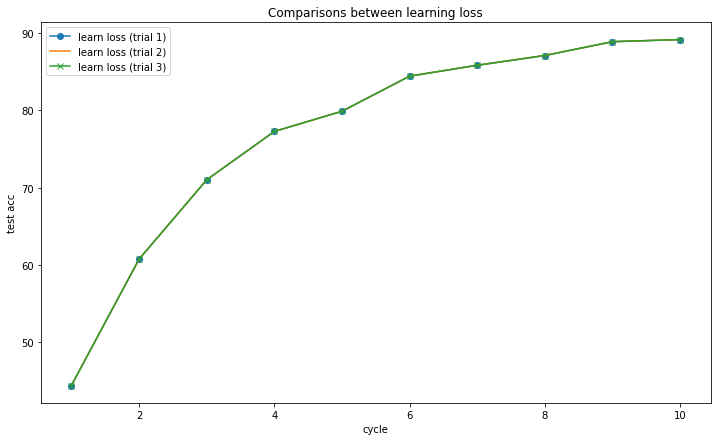

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7))
plt.title("Comparisons between learning loss")
plt.plot(np.arange(1,11,1),learn_loss, label = "learn loss (trial 1)", marker = 'o')
plt.plot(np.arange(1,11,1),learn_loss, label = "learn loss (trial 2)")
plt.plot(np.arange(1,11,1),learn_loss, label = "learn loss (trial 3)", marker = 'x')
# plt.plot(np.arange(1,8,1), kappa, label = "kappa")
plt.xlabel("cycle")
plt.ylabel("test acc")
plt.legend()
plt.show()

# Visualize original Results

In [198]:
import pandas as pd
import matplotlib.pyplot as plt

In [202]:
trials_dict.keys()

dict_keys(['trial0', 'trial1', 'trial2'])

In [205]:
trials_dict['trial0'].keys()

dict_keys(['train_acc_dict', 'test_acc_dict', 'train_loss_dict', 'test_loss_dict', 'train_backbone_loss_dict', 'test_backbone_loss_dict', 'train_module_loss_dict', 'test_module_loss_dict'])

In [199]:
train_acc_dict.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [211]:
trail1_cycle1_train_acc = trials_dict['trial0']['train_acc_dict']['1']
trail1_cycle2_train_acc = trials_dict['trial0']['train_acc_dict']['2']
trail1_cycle3_train_acc = trials_dict['trial0']['train_acc_dict']['3']
trail1_cycle4_train_acc = trials_dict['trial0']['train_acc_dict']['4']
trail1_cycle5_train_acc = trials_dict['trial0']['train_acc_dict']['5']
trail1_cycle6_train_acc = trials_dict['trial0']['train_acc_dict']['6']
trail1_cycle7_train_acc = trials_dict['trial0']['train_acc_dict']['7']
trail1_cycle8_train_acc = trials_dict['trial0']['train_acc_dict']['8']
trail1_cycle9_train_acc = trials_dict['trial0']['train_acc_dict']['9']
trail1_cycle10_train_acc = trials_dict['trial0']['train_acc_dict']['10']

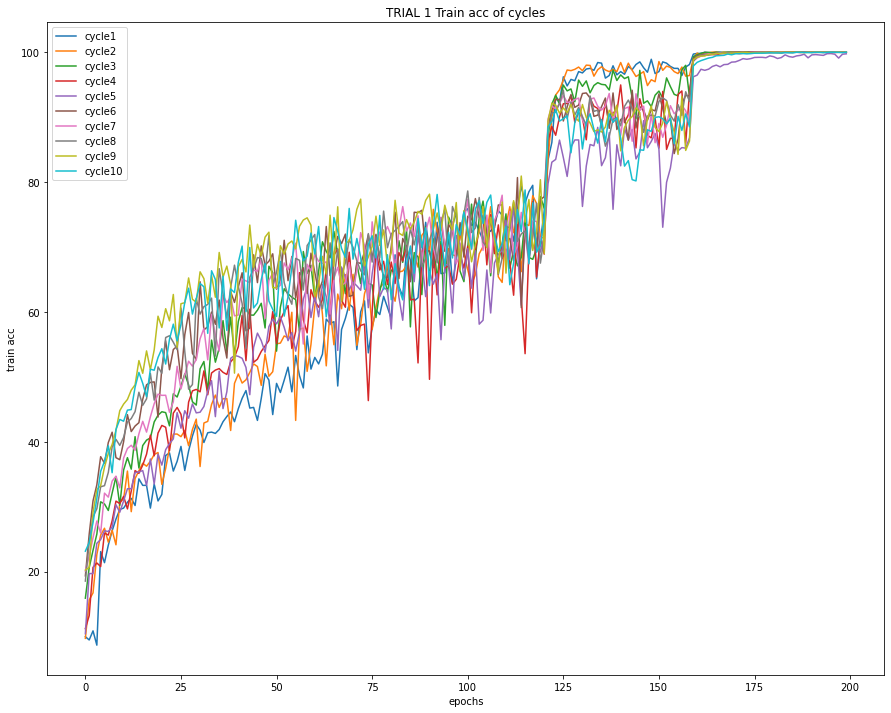

In [213]:
plt.figure(figsize = (15,12))
plt.title("TRIAL 1 Train acc of cycles")
plt.plot(trail1_cycle1_train_acc, label = "cycle1")
plt.plot(trail1_cycle2_train_acc, label = "cycle2")
plt.plot(trail1_cycle3_train_acc, label = "cycle3")
plt.plot(trail1_cycle4_train_acc, label = "cycle4")
plt.plot(trail1_cycle5_train_acc, label = "cycle5")
plt.plot(trail1_cycle6_train_acc, label = "cycle6")
plt.plot(trail1_cycle7_train_acc, label = "cycle7")
plt.plot(trail1_cycle8_train_acc, label = "cycle8")
plt.plot(trail1_cycle9_train_acc, label = "cycle9")
plt.plot(trail1_cycle10_train_acc, label = "cycle10")
plt.xlabel("epochs")
plt.ylabel("train acc")
plt.legend()
plt.show()

#### Train Acc

In [200]:
cycle1_train_acc = train_acc_dict['1']
cycle2_train_acc = train_acc_dict['2']
cycle3_train_acc = train_acc_dict['3']
cycle4_train_acc = train_acc_dict['4']
cycle5_train_acc = train_acc_dict['5']
cycle6_train_acc = train_acc_dict['6']
cycle7_train_acc = train_acc_dict['7']
cycle8_train_acc = train_acc_dict['8']
cycle9_train_acc = train_acc_dict['9']
cycle10_train_acc = train_acc_dict['10']

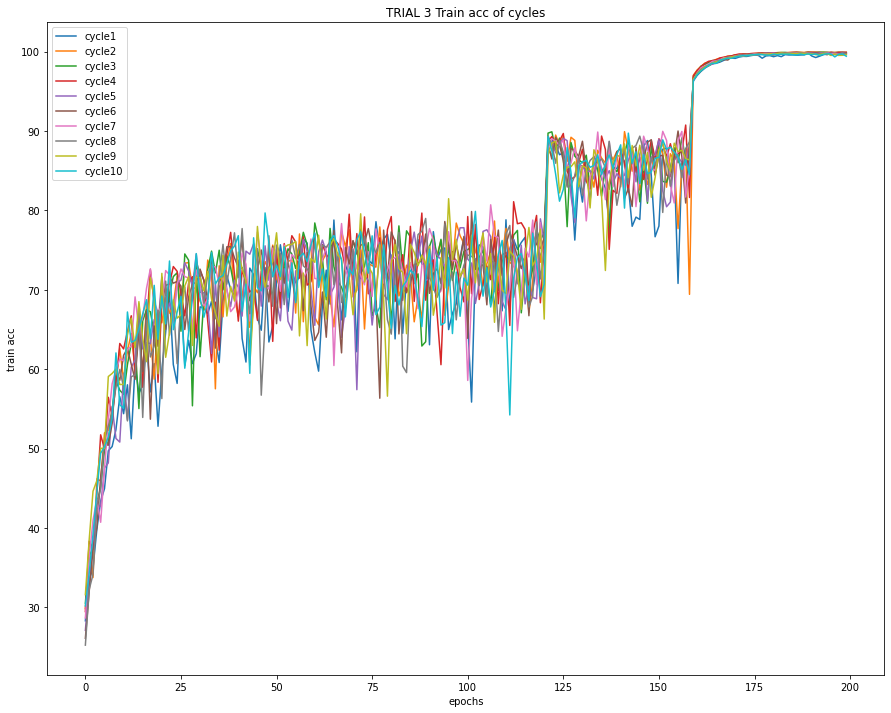

In [207]:
plt.figure(figsize = (15,12))
plt.title("TRIAL 3 Train acc of cycles")
plt.plot(cycle1_train_acc, label = "cycle1")
plt.plot(cycle2_train_acc, label = "cycle2")
plt.plot(cycle3_train_acc, label = "cycle3")
plt.plot(cycle4_train_acc, label = "cycle4")
plt.plot(cycle5_train_acc, label = "cycle5")
plt.plot(cycle6_train_acc, label = "cycle6")
plt.plot(cycle7_train_acc, label = "cycle7")
plt.plot(cycle8_train_acc, label = "cycle8")
plt.plot(cycle9_train_acc, label = "cycle9")
plt.plot(cycle10_train_acc, label = "cycle10")
plt.xlabel("epochs")
plt.ylabel("train acc")
plt.legend()

#### Test Acc

In [214]:
trail1_cycle1_test_acc = trials_dict['trial0']['test_acc_dict']['1']
trail1_cycle2_test_acc = trials_dict['trial0']['test_acc_dict']['2']
trail1_cycle3_test_acc = trials_dict['trial0']['test_acc_dict']['3']
trail1_cycle4_test_acc = trials_dict['trial0']['test_acc_dict']['4']
trail1_cycle5_test_acc = trials_dict['trial0']['test_acc_dict']['5']
trail1_cycle6_test_acc = trials_dict['trial0']['test_acc_dict']['6']
trail1_cycle7_test_acc = trials_dict['trial0']['test_acc_dict']['7']
trail1_cycle8_test_acc = trials_dict['trial0']['test_acc_dict']['8']
trail1_cycle9_test_acc = trials_dict['trial0']['test_acc_dict']['9']
trail1_cycle10_test_acc = trials_dict['trial0']['test_acc_dict']['10']

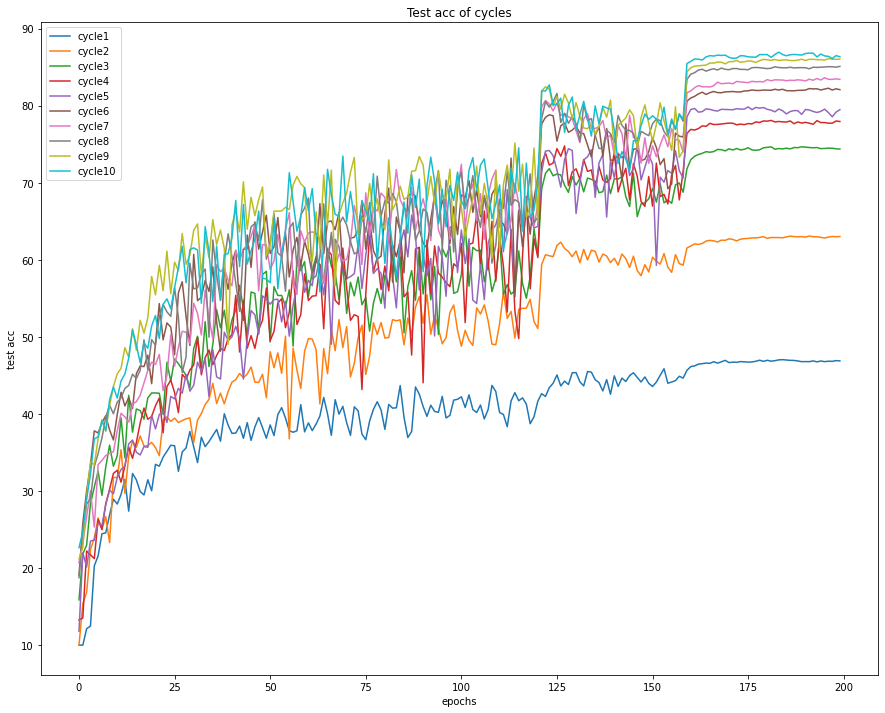

In [215]:
plt.figure(figsize = (15,12))
plt.title("Test acc of cycles")
plt.plot(trail1_cycle1_test_acc, label = "cycle1")
plt.plot(trail1_cycle2_test_acc, label = "cycle2")
plt.plot(trail1_cycle3_test_acc, label = "cycle3")
plt.plot(trail1_cycle4_test_acc, label = "cycle4")
plt.plot(trail1_cycle5_test_acc, label = "cycle5")
plt.plot(trail1_cycle6_test_acc, label = "cycle6")
plt.plot(trail1_cycle7_test_acc, label = "cycle7")
plt.plot(trail1_cycle8_test_acc, label = "cycle8")
plt.plot(trail1_cycle9_test_acc, label = "cycle9")
plt.plot(trail1_cycle10_test_acc, label = "cycle10")
plt.xlabel("epochs")
plt.ylabel("test acc")
plt.legend()

## Tendency of test acc per cycle

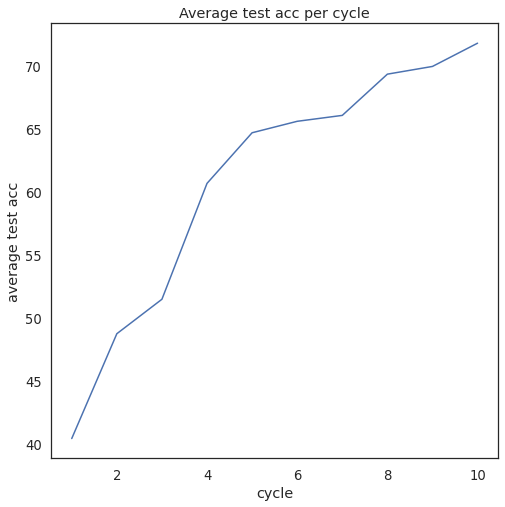

In [573]:
plt.figure(figsize = (8,8))
cycle_acc = [np.mean(cycle1_test_acc),np.mean(cycle2_test_acc),np.mean(cycle3_test_acc),np.mean(cycle4_test_acc),np.mean(cycle5_test_acc),np.mean(cycle6_test_acc),np.mean(cycle7_test_acc),np.mean(cycle8_test_acc),np.mean(cycle9_test_acc),np.mean(cycle10_test_acc)]
plt.title("Average test acc per cycle")
plt.plot(np.arange(1,11,1),cycle_acc)
plt.xlabel("cycle")
plt.ylabel("average test acc")
plt.show()

### Train acc vs. Test acc

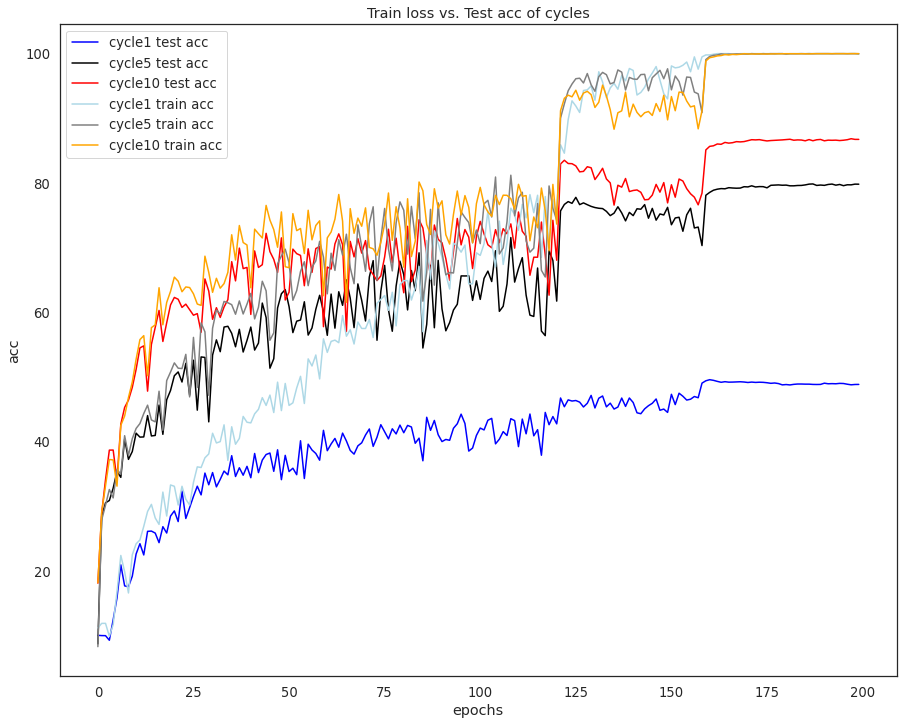

In [562]:
plt.figure(figsize = (15,12))
plt.title("Train loss vs. Test acc of cycles")

plt.plot(cycle1_test_acc, label = "cycle1 test acc", color = "blue")
plt.plot(cycle5_test_acc, label = "cycle5 test acc", color = "black")
plt.plot(cycle10_test_acc, label = "cycle10 test acc", color = "red")

plt.plot(cycle1_train_acc, label = "cycle1 train acc", color = "lightblue")
plt.plot(cycle5_train_acc, label = "cycle5 train acc", color = "gray")
plt.plot(cycle10_train_acc, label = "cycle10 train acc", color = "orange")

plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

train_backbone_loss_dict = {}
test_backbone_loss_dict = {}
train_acc_dict = {}
test_acc_dict = {}
train_module_loss_dict = {}
test_module_loss_dict = {}
train_loss_dict = {}
test_loss_dict = {}

#### Total Train Loss plot

In [505]:
cycle1_train_loss = train_loss_dict['1']
cycle2_train_loss = train_loss_dict['2']
cycle3_train_loss = train_loss_dict['3']
cycle4_train_loss = train_loss_dict['4']
cycle5_train_loss = train_loss_dict['5']
cycle6_train_loss = train_loss_dict['6']
cycle7_train_loss = train_loss_dict['7']
cycle8_train_loss = train_loss_dict['8']
cycle9_train_loss = train_loss_dict['9']
cycle10_train_loss = train_loss_dict['10']

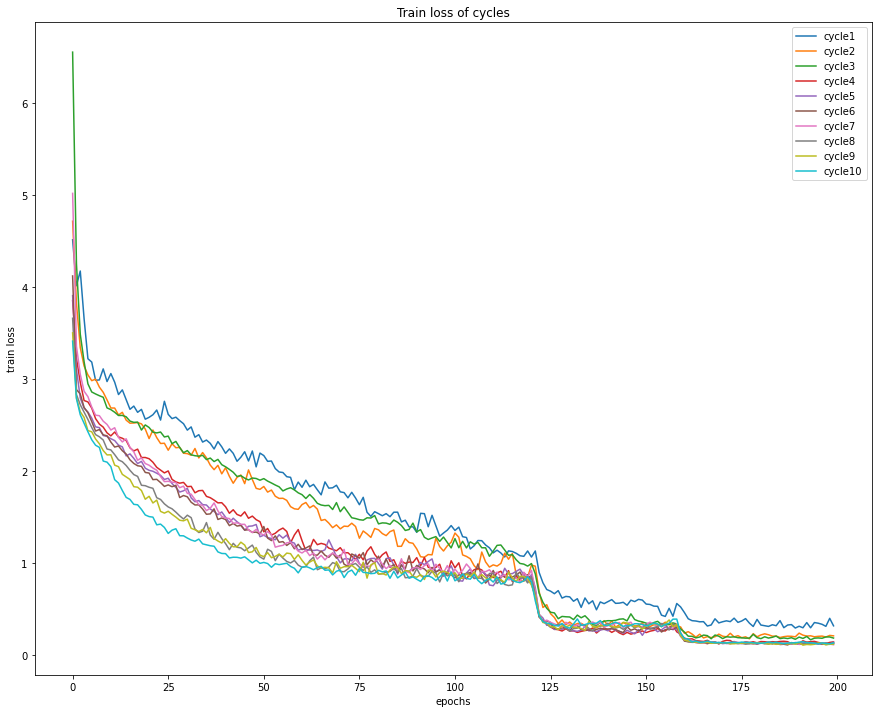

In [506]:
plt.figure(figsize = (15,12))
plt.title("Train loss of cycles")
plt.plot(cycle1_train_loss, label = "cycle1")
plt.plot(cycle2_train_loss, label = "cycle2")
plt.plot(cycle3_train_loss, label = "cycle3")
plt.plot(cycle4_train_loss, label = "cycle4")
plt.plot(cycle5_train_loss, label = "cycle5")
plt.plot(cycle6_train_loss, label = "cycle6")
plt.plot(cycle7_train_loss, label = "cycle7")
plt.plot(cycle8_train_loss, label = "cycle8")
plt.plot(cycle9_train_loss, label = "cycle9")
plt.plot(cycle10_train_loss, label = "cycle10")
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.legend()

train backbone loss

In [503]:
cycle1_train_backbone_loss = train_backbone_loss_dict['1']
cycle2_train_backbone_loss = train_backbone_loss_dict['2']
cycle3_train_backbone_loss = train_backbone_loss_dict['3']
cycle4_train_backbone_loss = train_backbone_loss_dict['4']
cycle5_train_backbone_loss = train_backbone_loss_dict['5']
cycle6_train_backbone_loss = train_backbone_loss_dict['6']
cycle7_train_backbone_loss = train_backbone_loss_dict['7']
cycle8_train_backbone_loss = train_backbone_loss_dict['8']
cycle9_train_backbone_loss = train_backbone_loss_dict['9']
cycle10_train_backbone_loss = train_backbone_loss_dict['10']

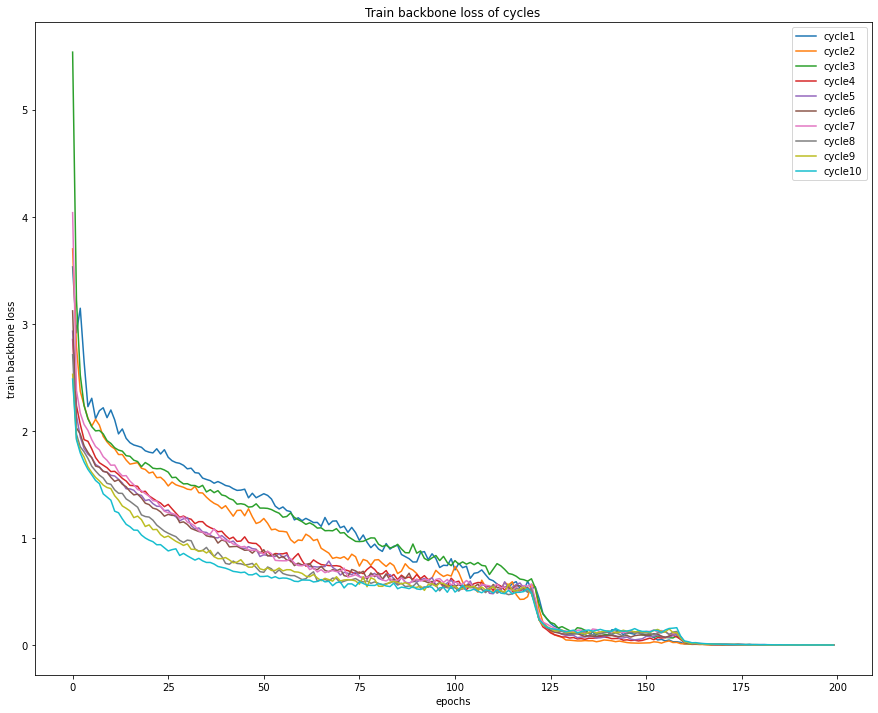

In [508]:
plt.figure(figsize = (15,12))
plt.title("Train backbone loss of cycles")
plt.plot(cycle1_train_backbone_loss, label = "cycle1")
plt.plot(cycle2_train_backbone_loss, label = "cycle2")
plt.plot(cycle3_train_backbone_loss, label = "cycle3")
plt.plot(cycle4_train_backbone_loss, label = "cycle4")
plt.plot(cycle5_train_backbone_loss, label = "cycle5")
plt.plot(cycle6_train_backbone_loss, label = "cycle6")
plt.plot(cycle7_train_backbone_loss, label = "cycle7")
plt.plot(cycle8_train_backbone_loss, label = "cycle8")
plt.plot(cycle9_train_backbone_loss, label = "cycle9")
plt.plot(cycle10_train_backbone_loss, label = "cycle10")
plt.xlabel("epochs")
plt.ylabel("train backbone loss")
plt.legend()

train module loss

In [509]:
cycle1_train_module_loss = train_module_loss_dict['1']
cycle2_train_module_loss = train_module_loss_dict['2']
cycle3_train_module_loss = train_module_loss_dict['3']
cycle4_train_module_loss = train_module_loss_dict['4']
cycle5_train_module_loss = train_module_loss_dict['5']
cycle6_train_module_loss = train_module_loss_dict['6']
cycle7_train_module_loss = train_module_loss_dict['7']
cycle8_train_module_loss = train_module_loss_dict['8']
cycle9_train_module_loss = train_module_loss_dict['9']
cycle10_train_module_loss = train_module_loss_dict['10']

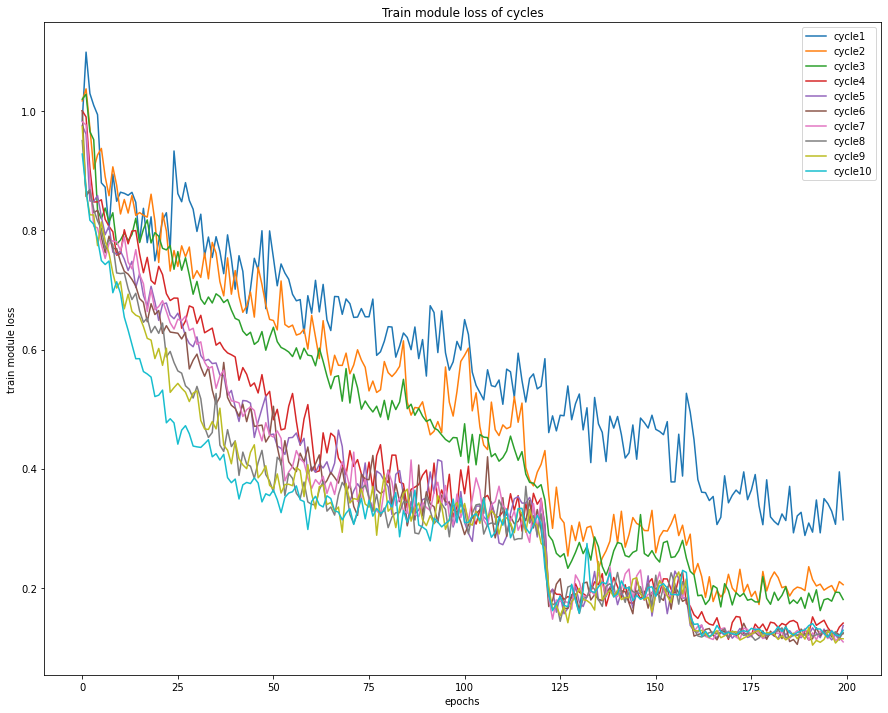

In [510]:
plt.figure(figsize = (15,12))
plt.title("Train module loss of cycles")
plt.plot(cycle1_train_module_loss, label = "cycle1")
plt.plot(cycle2_train_module_loss, label = "cycle2")
plt.plot(cycle3_train_module_loss, label = "cycle3")
plt.plot(cycle4_train_module_loss, label = "cycle4")
plt.plot(cycle5_train_module_loss, label = "cycle5")
plt.plot(cycle6_train_module_loss, label = "cycle6")
plt.plot(cycle7_train_module_loss, label = "cycle7")
plt.plot(cycle8_train_module_loss, label = "cycle8")
plt.plot(cycle9_train_module_loss, label = "cycle9")
plt.plot(cycle10_train_module_loss, label = "cycle10")
plt.xlabel("epochs")
plt.ylabel("train module loss")
plt.legend()

### Total Test Loss plot

In [520]:
cycle1_test_loss = test_loss_dict['1']
cycle2_test_loss = test_loss_dict['2']
cycle3_test_loss = test_loss_dict['3']
cycle4_test_loss = test_loss_dict['4']
cycle5_test_loss = test_loss_dict['5']
cycle6_test_loss = test_loss_dict['6']
cycle7_test_loss = test_loss_dict['7']
cycle8_test_loss = test_loss_dict['8']
cycle9_test_loss = test_loss_dict['9']
cycle10_test_loss = test_loss_dict['10']

In [526]:
print(np.mean(cycle1_test_loss))
print(np.mean(cycle2_test_loss))
print(np.mean(cycle3_test_loss))
print(np.mean(cycle4_test_loss))
print(np.mean(cycle5_test_loss))
print(np.mean(cycle6_test_loss))
print(np.mean(cycle7_test_loss))
print(np.mean(cycle8_test_loss))
print(np.mean(cycle9_test_loss))
print(np.mean(cycle10_test_loss))

457.9275037518262
10.259284203958511
59.458403908133505
11.905775488948823
3.465706936621666
3.3387314686655998
3.5017912392616277
3.250223258817196
3.2106215502500532
3.179032401740551


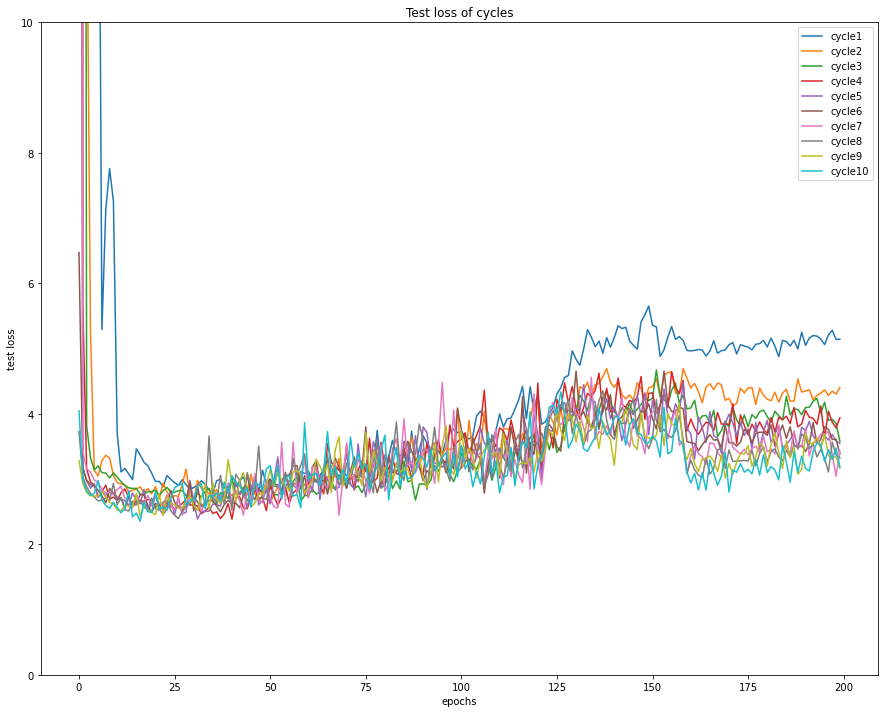

In [527]:
plt.figure(figsize = (15,12))
plt.title("Test loss of cycles")
plt.plot(cycle1_test_loss, label = "cycle1")
plt.plot(cycle2_test_loss, label = "cycle2")
plt.plot(cycle3_test_loss, label = "cycle3")
plt.plot(cycle4_test_loss, label = "cycle4")
plt.plot(cycle5_test_loss, label = "cycle5")
plt.plot(cycle6_test_loss, label = "cycle6")
plt.plot(cycle7_test_loss, label = "cycle7")
plt.plot(cycle8_test_loss, label = "cycle8")
plt.plot(cycle9_test_loss, label = "cycle9")
plt.plot(cycle10_test_loss, label = "cycle10")
plt.xlabel("epochs")
plt.ylabel("test loss")
plt.ylim(0,10)
plt.legend()